## Implementação da validação cruzada para avaliação de modelos

### 1. Preparação dos dados

In [1]:
# importando bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Lendo conjuntos de dados
diabetes = pd.read_csv('diabetes.csv')

In [3]:
# Apresentaodno cinco primeiras linhas do conjunto de dados
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Apresentando a classificação dos pacientes 
diabetes.groupby('Outcome').size()

Outcome
0    500
1    268
dtype: int64

In [5]:
# verificando a completude dos dados que iram ser usados
pd.isna(diabetes).sum()
pd.isnull(diabetes).sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Outcome
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

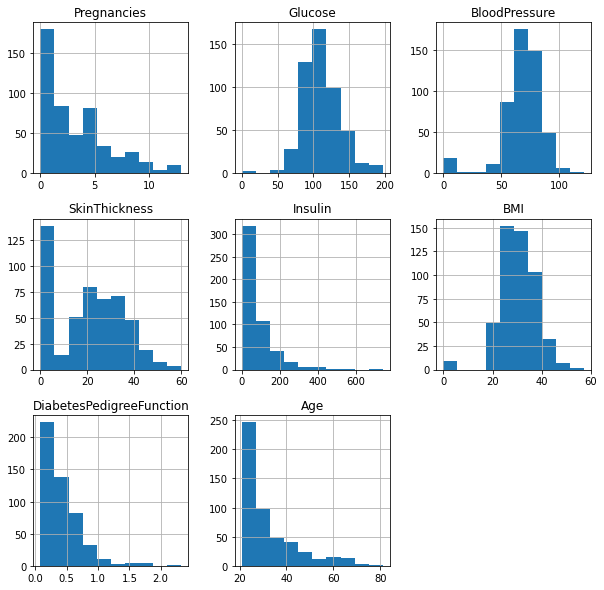

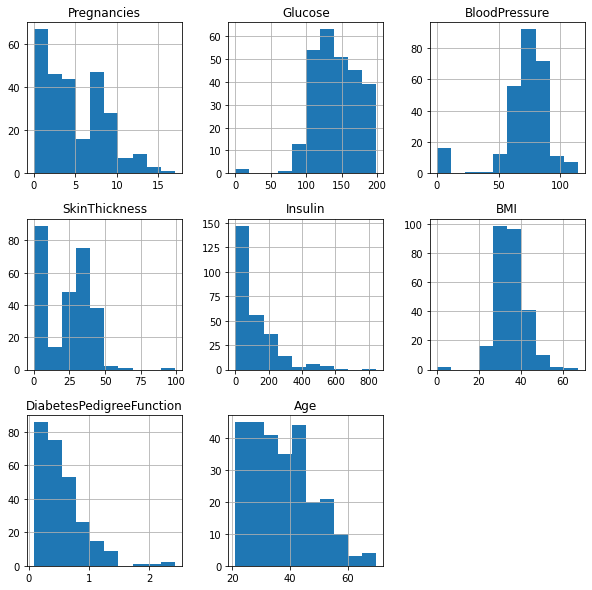

In [6]:
# apresentado um histograma para entender melhor a distribuicao dos dados
diabetes.groupby('Outcome').hist(figsize = (10, 10))

In [7]:
diabetes_mod = diabetes[(diabetes.BloodPressure != 0) & (diabetes.BMI != 0) & (diabetes.Glucose != 0)]

Outcome
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

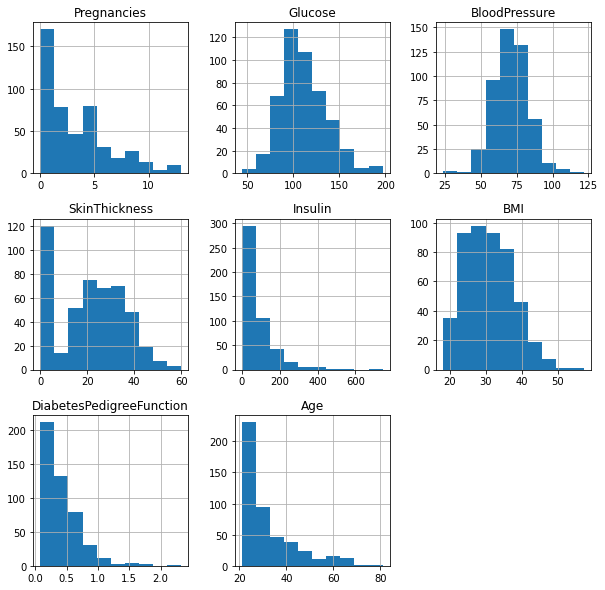

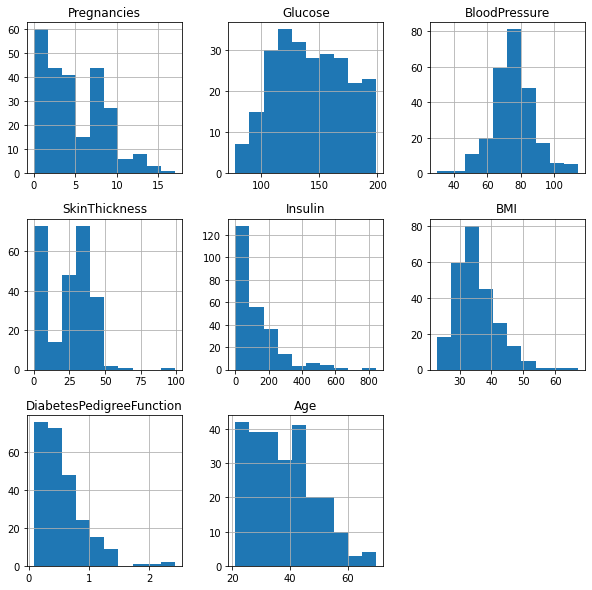

In [8]:
diabetes_mod.groupby('Outcome').hist(figsize = (10, 10))